In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['Raw_Data_JSON', 'nasa.csv']


In [24]:
df = pd.read_csv('../input/nasa.csv')
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbiting Body,Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-01,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,62753692.0,38993336.0,Earth,17,2017-04-06 08:36:37,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,1995-01-01,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,57298148.0,35603420.0,Earth,21,2017-04-06 08:32:49,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,1995-01-08,789552000000,7.590711,27326.560182,16979.661798,0.050956,19.821890,7622911.5,4736657.5,Earth,22,2017-04-06 09:20:19,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,1995-01-15,790156800000,11.173874,40225.948191,24994.839864,0.285322,110.990387,42683616.0,26522368.0,Earth,7,2017-04-06 09:15:49,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-15,790156800000,9.840831,35426.991794,22012.954985,0.407832,158.646713,61010824.0,37910368.0,Earth,25,2017-04-06 08:57:58,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


I used **XGBClassifier model** for this task. 
Importing relevant packages:[](http://)


In [25]:
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance
from numpy import sort
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

We have min and max estimated diameter features for orbit as **'Est Dia in KM(min)'** and **'Est Dia in KM(max)'**. I found average of it and created new column as 'avg_dia' with following line of code.

In [29]:
df['avg_dia'] = df[['Est Dia in KM(min)', 'Est Dia in KM(max)']].mean(axis=1)

These are the features I chose firstly in order to train data. Simply, nearly all numeric datas. 

In [30]:
X = df[['Absolute Magnitude','avg_dia', 'Relative Velocity km per hr','Miss Dist.(kilometers)','Orbit Uncertainity',
        'Minimum Orbit Intersection', 'Jupiter Tisserand Invariant','Epoch Osculation','Eccentricity','Semi Major Axis',
        'Inclination','Asc Node Longitude','Orbital Period','Perihelion Distance','Perihelion Arg',
        'Aphelion Dist','Perihelion Time','Mean Anomaly','Mean Motion']]
X.head()

,Absolute Magnitude,avg_dia,Relative Velocity km per hr,Miss Dist.(kilometers),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
0,21.6,0.205846,22017.003799,62753692.0,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551
1,21.3,0.236343,65210.346095,57298148.0,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330
2,20.3,0.374578,27326.560182,7622911.5,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371
3,27.4,0.014241,40225.948191,42683616.0,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277
4,21.6,0.205846,35426.991794,61010824.0,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395


I converted target column **(Hazardous)** to the 0 and 1 in order to be able to train data, with following line of code:

In [31]:
y = df['Hazardous'].astype(int)
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Hazardous, dtype: int64

After that I fitted data to the model and then by using **plot_importance(model)** I defined which features are more **important** to train data.

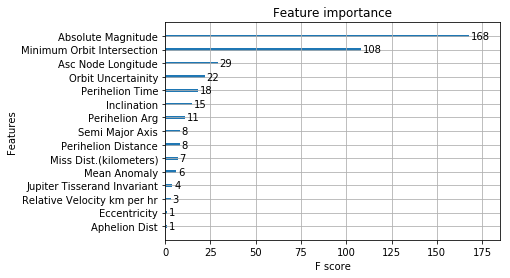

In [32]:
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
pyplot.show()

For interest, we can test multiple thresholds for selecting features by feature importance. Specifically, the feature importance of each input variable, essentially allowing us to test each subset of features by importance, starting with all features and ending with a subset with the most important feature.

The complete code listing is provided below.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

thresholds = sort(model.feature_importances_)
for thresh in thresholds:

	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)

	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)

	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 99.61%
Thresh=0.000, n=19, Accuracy: 99.61%
Thresh=0.000, n=19, Accuracy: 99.61%
Thresh=0.000, n=19, Accuracy: 99.61%
Thresh=0.000, n=19, Accuracy: 99.61%
Thresh=0.004, n=15, Accuracy: 99.61%
Thresh=0.006, n=14, Accuracy: 99.61%
Thresh=0.006, n=13, Accuracy: 99.61%
Thresh=0.007, n=12, Accuracy: 99.61%
Thresh=0.007, n=11, Accuracy: 99.61%
Thresh=0.009, n=10, Accuracy: 99.61%
Thresh=0.011, n=9, Accuracy: 99.61%
Thresh=0.011, n=8, Accuracy: 99.61%
Thresh=0.011, n=7, Accuracy: 99.61%
Thresh=0.013, n=6, Accuracy: 99.68%
Thresh=0.013, n=5, Accuracy: 99.61%
Thresh=0.017, n=4, Accuracy: 99.61%
Thresh=0.018, n=3, Accuracy: 99.61%
Thresh=0.229, n=2, Accuracy: 99.68%
Thresh=0.637, n=1, Accuracy: 84.10%


We get **99,61%** accuracy by using firstly chosen features. But from the output above we can see that all those features is not changing the result to much.
Surprisingly, from the above method we can se that we can reach to the **99,68%** accuracy just using two features.
Which are:
* **Absolute Magnitude and Minimum Orbit Intersection**

So, after that I only chose those 2 columns as a feature:

In [34]:
X = df[['Absolute Magnitude','Minimum Orbit Intersection']]
y = df['Hazardous'].astype(int)
X.head()


,Absolute Magnitude,Minimum Orbit Intersection
0,21.6,0.025282
1,21.3,0.186935
2,20.3,0.043058
3,27.4,0.005512
4,21.6,0.034798


Split data to the train split again and fit the **XGBClassifier** model. And then predict the test data and get score. We wil get **99.68%** accuracy!

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.68%
